2025-05-27 19:07:46,484 - __main__ - INFO - Starting stock prediction system
2025-05-27 19:07:46,485 - __main__ - INFO - Downloading data for AAPL


📝 Logging to: stock_predictions\prediction.log

📊 Processing AAPL...
YF.download() has changed argument auto_adjust default to True


2025-05-27 19:07:49,399 - __main__ - INFO - Successfully downloaded 1255 records for AAPL



📈 AAPL - Predicted Prices for next 10 days:
--------------------------------------------------
2025-05-12: $209.81
2025-05-13: $211.86
2025-05-14: $211.28
2025-05-15: $210.44
2025-05-16: $210.26
2025-05-17: $207.88
2025-05-18: $206.04
2025-05-19: $201.48
2025-05-20: $200.78
2025-05-21: $194.95

🎯 Model Performance:
   Training Accuracy: 95.65%
   R² Score: 0.9435
   Training MAPE: 4.35%
   Cross-Validation MAPE: 4.70±0.48%


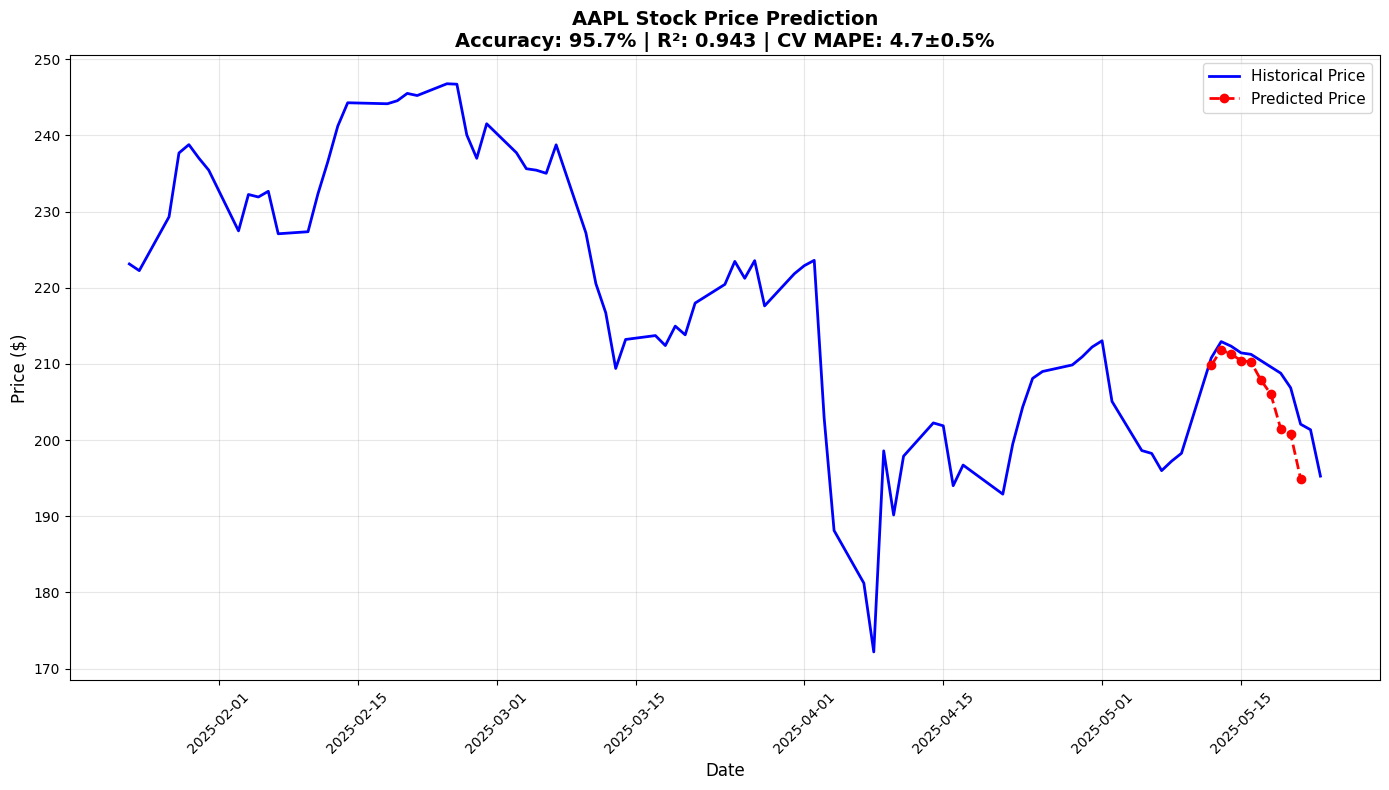

2025-05-27 19:07:50,173 - __main__ - INFO - Plot saved to stock_predictions\AAPL_prediction.png
2025-05-27 19:07:50,181 - __main__ - INFO - Downloading data for MSFT



📊 Processing MSFT...


2025-05-27 19:07:50,456 - __main__ - INFO - Successfully downloaded 1255 records for MSFT



📈 MSFT - Predicted Prices for next 10 days:
--------------------------------------------------
2025-05-12: $448.45
2025-05-13: $448.34
2025-05-14: $452.07
2025-05-15: $453.07
2025-05-16: $454.20
2025-05-17: $458.73
2025-05-18: $458.04
2025-05-19: $452.52
2025-05-20: $454.78
2025-05-21: $450.17

🎯 Model Performance:
   Training Accuracy: 96.20%
   R² Score: 0.9636
   Training MAPE: 3.80%
   Cross-Validation MAPE: 4.64±0.98%


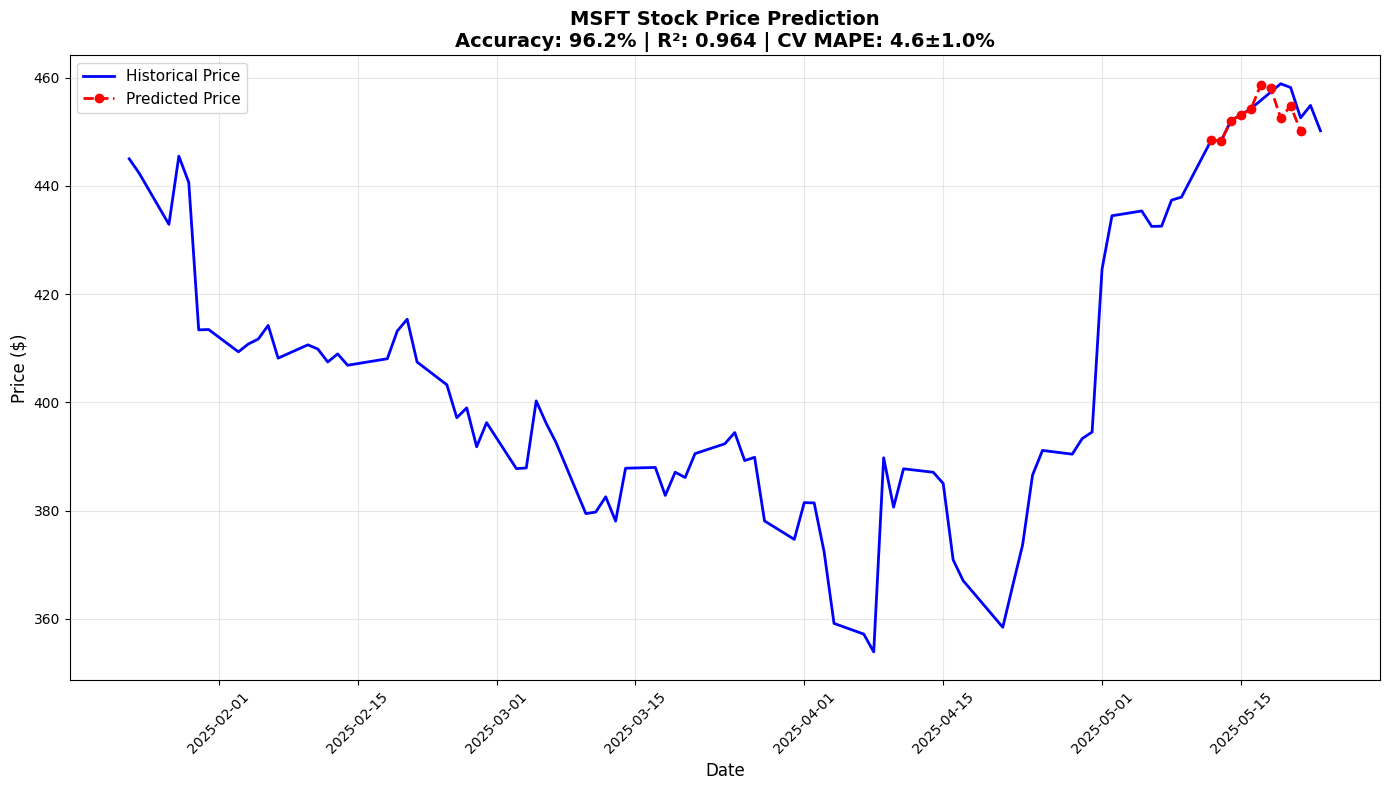

2025-05-27 19:07:51,116 - __main__ - INFO - Plot saved to stock_predictions\MSFT_prediction.png
2025-05-27 19:07:51,117 - __main__ - INFO - Downloading data for GOOGL



📊 Processing GOOGL...


2025-05-27 19:07:51,364 - __main__ - INFO - Successfully downloaded 1255 records for GOOGL



📈 GOOGL - Predicted Prices for next 10 days:
--------------------------------------------------
2025-05-12: $158.21
2025-05-13: $159.25
2025-05-14: $164.90
2025-05-15: $163.54
2025-05-16: $165.70
2025-05-17: $166.04
2025-05-18: $163.56
2025-05-19: $167.99
2025-05-20: $170.23
2025-05-21: $167.91

🎯 Model Performance:
   Training Accuracy: 95.66%
   R² Score: 0.9503
   Training MAPE: 4.34%
   Cross-Validation MAPE: 4.43±0.92%


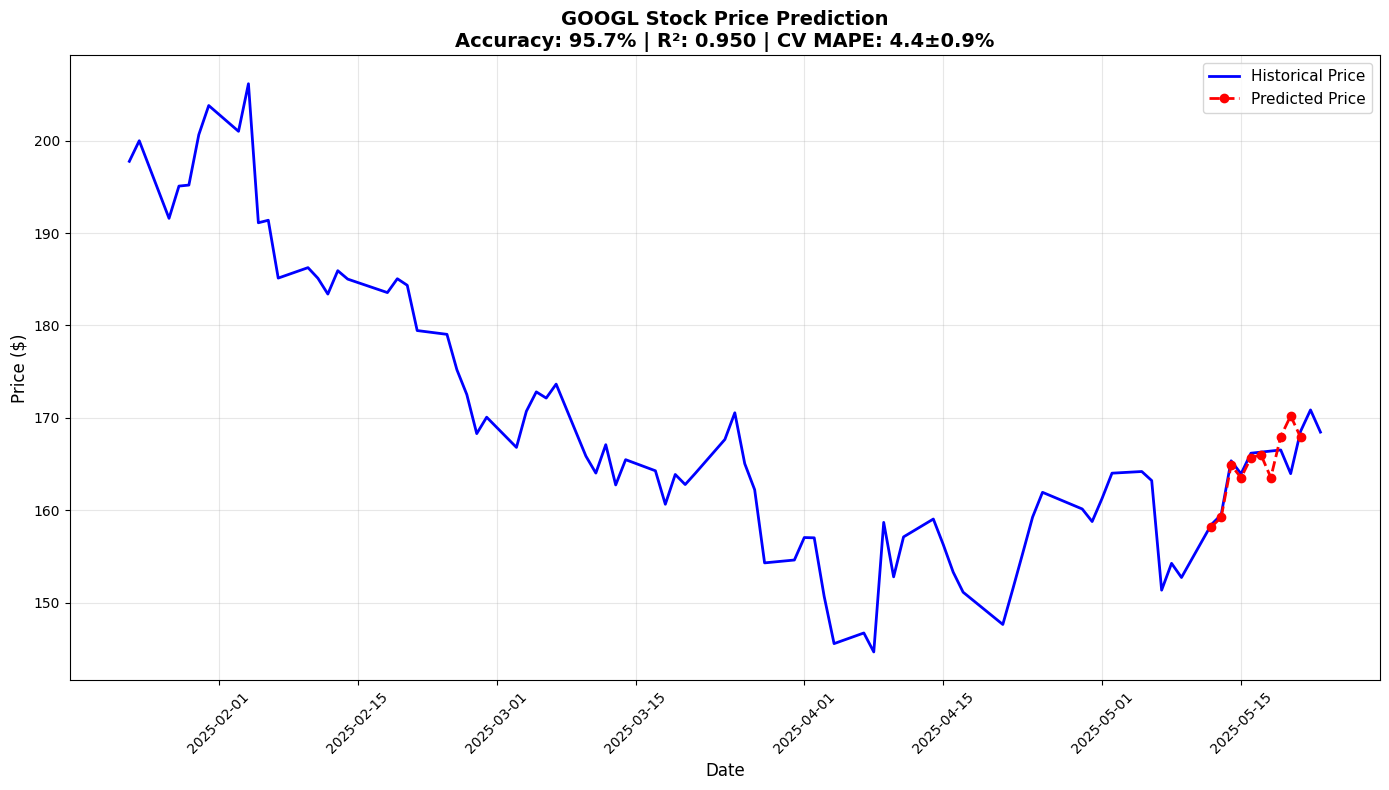

2025-05-27 19:07:52,048 - __main__ - INFO - Plot saved to stock_predictions\GOOGL_prediction.png
2025-05-27 19:07:52,049 - __main__ - INFO - Downloading data for AMZN



📊 Processing AMZN...


2025-05-27 19:07:52,303 - __main__ - INFO - Successfully downloaded 1255 records for AMZN



📈 AMZN - Predicted Prices for next 10 days:
--------------------------------------------------
2025-05-12: $207.12
2025-05-13: $209.75
2025-05-14: $208.67
2025-05-15: $203.79
2025-05-16: $204.20
2025-05-17: $204.74
2025-05-18: $202.74
2025-05-19: $199.90
2025-05-20: $201.81
2025-05-21: $199.78

🎯 Model Performance:
   Training Accuracy: 94.87%
   R² Score: 0.9105
   Training MAPE: 5.13%
   Cross-Validation MAPE: 6.69±4.29%


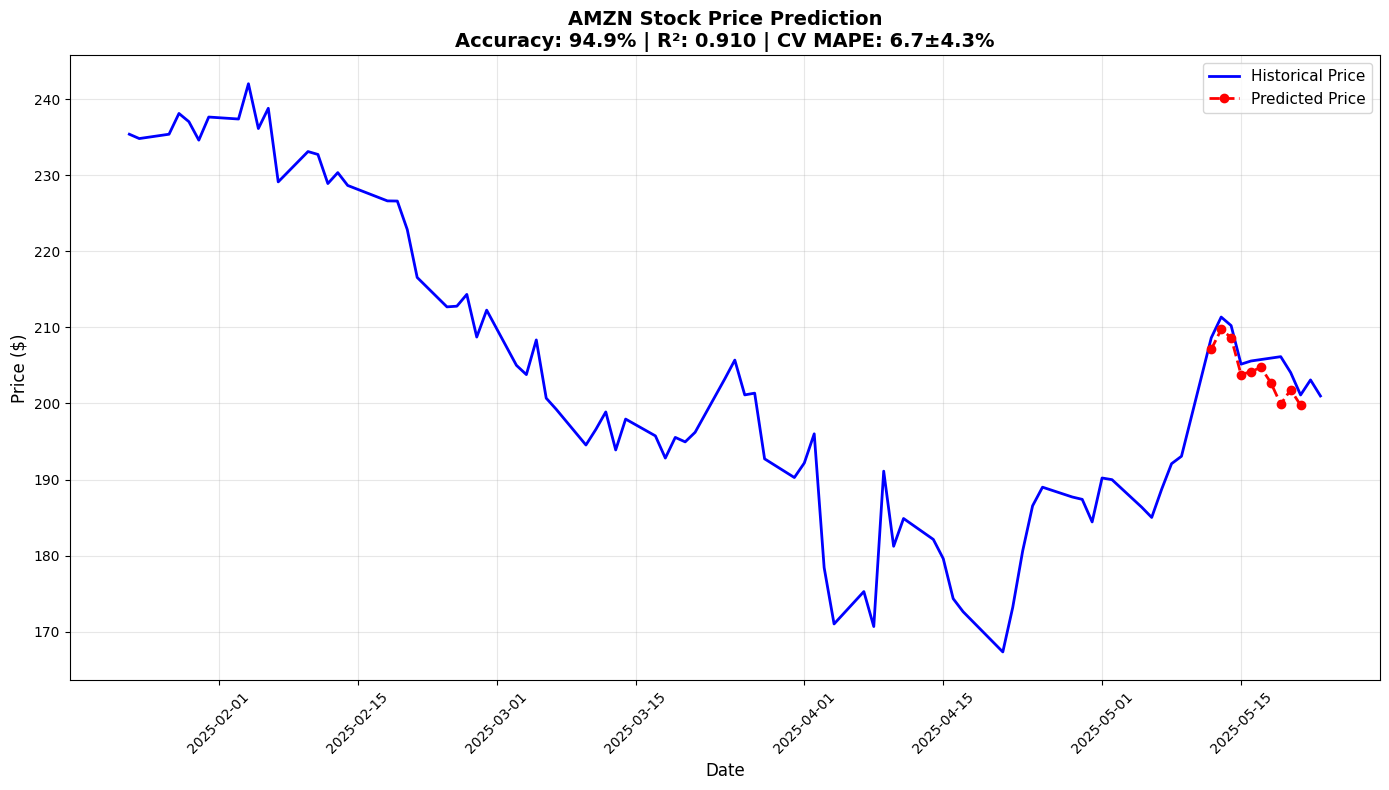

2025-05-27 19:07:52,982 - __main__ - INFO - Plot saved to stock_predictions\AMZN_prediction.png
2025-05-27 19:07:52,984 - __main__ - INFO - Downloading data for TSLA



📊 Processing TSLA...


2025-05-27 19:07:53,206 - __main__ - INFO - Successfully downloaded 1255 records for TSLA



📈 TSLA - Predicted Prices for next 10 days:
--------------------------------------------------
2025-05-12: $311.36
2025-05-13: $325.33
2025-05-14: $337.45
2025-05-15: $333.12
2025-05-16: $339.49
2025-05-17: $332.47
2025-05-18: $334.01
2025-05-19: $325.82
2025-05-20: $331.54
2025-05-21: $330.02

🎯 Model Performance:
   Training Accuracy: 89.90%
   R² Score: 0.8172
   Training MAPE: 10.10%
   Cross-Validation MAPE: 9.84±1.43%


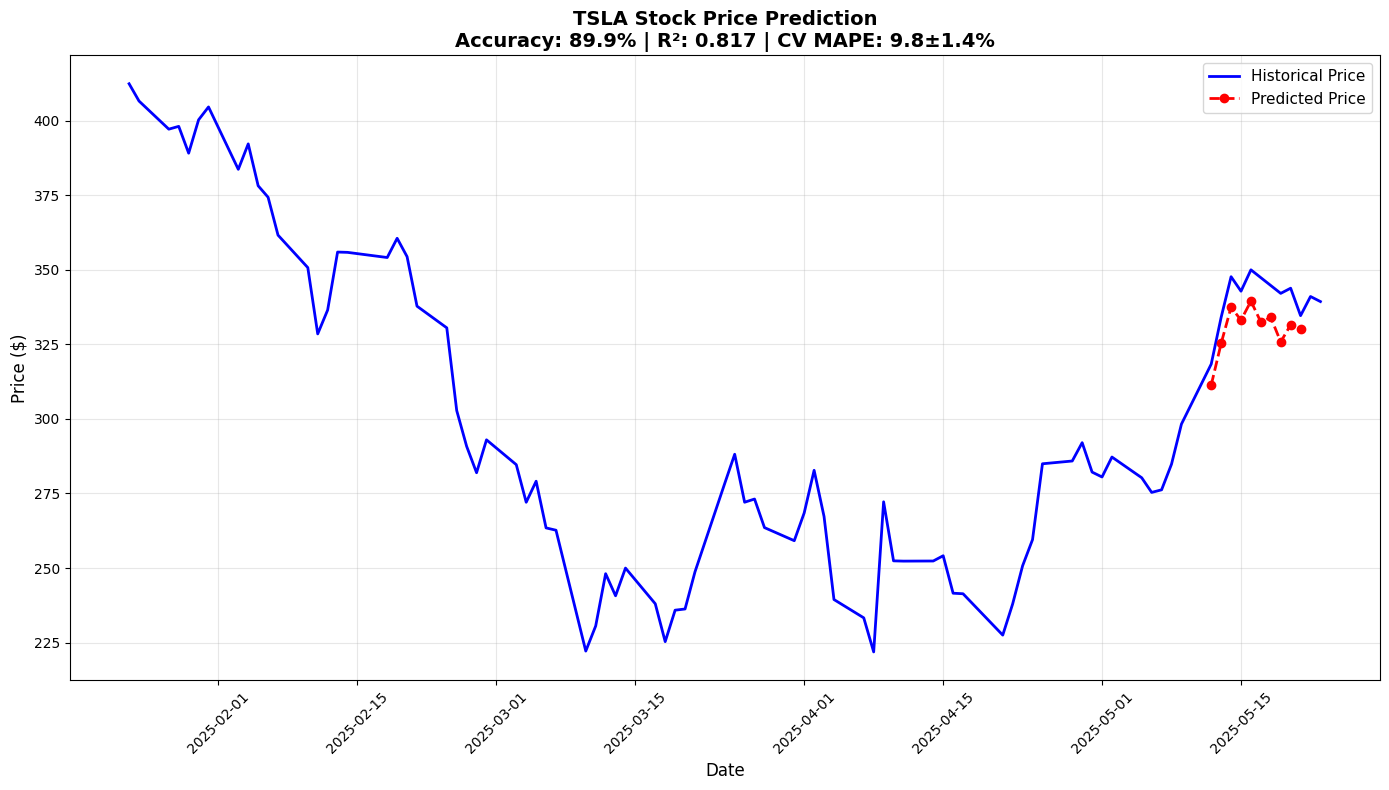

2025-05-27 19:07:53,894 - __main__ - INFO - Plot saved to stock_predictions\TSLA_prediction.png
2025-05-27 19:07:53,895 - __main__ - INFO - Completed predictions for 5/5 stocks
2025-05-27 19:07:53,912 - __main__ - INFO - Results summary saved to stock_predictions\prediction_summary.csv



PREDICTION SUMMARY
Ticker  Accuracy (%)  R² Score  MAPE (%)  CV MAPE Mean (%)  CV MAPE Std (%)  Latest Prediction ($)
  AAPL         95.65    0.9435      4.35              4.70             0.48                 194.95
  MSFT         96.20    0.9636      3.80              4.64             0.98                 450.17
 GOOGL         95.66    0.9503      4.34              4.43             0.92                 167.91
  AMZN         94.87    0.9105      5.13              6.69             4.29                 199.78
  TSLA         89.90    0.8172     10.10              9.84             1.43                 330.02

✅ Prediction pipeline completed successfully!
📁 Results saved to: stock_predictions/


In [4]:
"""
Industrial-grade stock price prediction system.

This module provides a robust framework for downloading stock data,
training prediction models, and generating forecasts with proper
error handling and logging.
"""

import logging
from dataclasses import dataclass
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


@dataclass
class PredictionConfig:
    """Configuration for stock prediction parameters."""
    
    stocks: List[str]
    training_years: int = 5
    forecast_days: int = 10
    validation_splits: int = 5
    plot_months: int = 4
    output_dir: str = "results"
    log_level: str = "INFO"


@dataclass
class ModelMetrics:
    """Container for model performance metrics."""
    
    accuracy: float
    r2_score: float
    mape: float
    cv_score_mean: float
    cv_score_std: float


class StockDataManager:
    """Handles stock data downloading and preprocessing."""
    
    def __init__(self, logger: logging.Logger):
        self.logger = logger
    
    def download_stock_data(
        self, 
        ticker: str, 
        start_date: datetime, 
        end_date: datetime
    ) -> Optional[pd.DataFrame]:
        """
        Download and preprocess stock data for a given ticker.
        
        Args:
            ticker: Stock ticker symbol
            start_date: Start date for data retrieval
            end_date: End date for data retrieval
            
        Returns:
            DataFrame with processed stock data or None if failed
        """
        try:
            self.logger.info(f"Downloading data for {ticker}")
            
            # Download data with retry logic
            df = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if df.empty:
                self.logger.warning(f"No data retrieved for {ticker}")
                return None
            
            # Select and clean data
            df = df[['Close']].copy()
            df.dropna(inplace=True)
            
            if len(df) < 100:  # Minimum data requirement
                self.logger.warning(f"Insufficient data for {ticker}: {len(df)} records")
                return None
            
            self.logger.info(f"Successfully downloaded {len(df)} records for {ticker}")
            return df
            
        except Exception as e:
            self.logger.error(f"Failed to download data for {ticker}: {str(e)}")
            return None


class StockPredictor:
    """Handles model training and prediction for stock prices."""
    
    def __init__(self, logger: logging.Logger):
        self.logger = logger
        self.model = LinearRegression()
    
    def prepare_features(
        self, 
        df: pd.DataFrame, 
        forecast_days: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare features and targets for model training.
        
        Args:
            df: DataFrame with stock data
            forecast_days: Number of days to forecast
            
        Returns:
            Tuple of (features, targets)
        """
        # Create shifted target variable
        df_copy = df.copy()
        df_copy['Target'] = df_copy['Close'].shift(-forecast_days)
        
        # Remove rows with NaN targets
        valid_data = df_copy.dropna()
        
        X = valid_data[['Close']].values
        y = valid_data['Target'].values
        
        return X, y
    
    def train_model(self, X: np.ndarray, y: np.ndarray) -> ModelMetrics:
        """
        Train the prediction model and calculate performance metrics.
        
        Args:
            X: Feature matrix
            y: Target vector
            
        Returns:
            ModelMetrics object with performance statistics
        """
        try:
            # Train the model
            self.model.fit(X, y)
            
            # Make predictions on training data
            y_pred = self.model.predict(X)
            
            # Calculate metrics
            mape = mean_absolute_percentage_error(y, y_pred) * 100
            accuracy = max(0, 100 - mape)  # Ensure non-negative accuracy
            r2 = r2_score(y, y_pred)
            
            # Cross-validation for more robust evaluation
            tscv = TimeSeriesSplit(n_splits=5)
            cv_scores = cross_val_score(
                self.model, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error'
            )
            cv_score_mean = -cv_scores.mean() * 100
            cv_score_std = cv_scores.std() * 100
            
            return ModelMetrics(
                accuracy=accuracy,
                r2_score=r2,
                mape=mape,
                cv_score_mean=cv_score_mean,
                cv_score_std=cv_score_std
            )
            
        except Exception as e:
            self.logger.error(f"Model training failed: {str(e)}")
            raise
    
    def generate_forecast(
        self, 
        df: pd.DataFrame, 
        forecast_days: int
    ) -> pd.DataFrame:
        """
        Generate price forecasts for the specified number of days.
        
        Args:
            df: DataFrame with stock data
            forecast_days: Number of days to forecast
            
        Returns:
            DataFrame with forecast results
        """
        try:
            # Get the most recent prices for prediction
            recent_prices = df['Close'].tail(forecast_days).values.reshape(-1, 1)
            
            # Generate predictions
            forecast = self.model.predict(recent_prices)
            
            # Create forecast DataFrame
            forecast_dates = pd.date_range(
                start=df.index[-forecast_days],
                periods=forecast_days,
                freq='D'
            )
            
            forecast_df = pd.DataFrame({
                'Predicted_Price': forecast
            }, index=forecast_dates)
            
            return forecast_df
            
        except Exception as e:
            self.logger.error(f"Forecast generation failed: {str(e)}")
            raise


class ResultsVisualizer:
    """Handles visualization and result presentation."""
    
    def __init__(self, logger: logging.Logger, output_dir: str):
        self.logger = logger
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
    
    def plot_predictions(
        self,
        ticker: str,
        df: pd.DataFrame,
        forecast_df: pd.DataFrame,
        metrics: ModelMetrics,
        plot_months: int
    ) -> None:
        """
        Create and save prediction visualization.
        
        Args:
            ticker: Stock ticker symbol
            df: Historical stock data
            forecast_df: Forecast results
            metrics: Model performance metrics
            plot_months: Number of months to show in plot
        """
        try:
            plt.figure(figsize=(14, 8))
            
            # Filter recent data for plotting
            cutoff_date = df.index[-1] - timedelta(days=plot_months * 30)
            recent_data = df[df.index >= cutoff_date]
            
            # Plot historical and predicted prices
            plt.plot(
                recent_data.index, 
                recent_data['Close'], 
                label='Historical Price', 
                linewidth=2,
                color='blue'
            )
            
            plt.plot(
                forecast_df.index, 
                forecast_df['Predicted_Price'], 
                label='Predicted Price', 
                linestyle='--', 
                linewidth=2, 
                marker='o',
                color='red',
                markersize=6
            )
            
            # Formatting
            plt.title(
                f'{ticker} Stock Price Prediction\n'
                f'Accuracy: {metrics.accuracy:.1f}% | R²: {metrics.r2_score:.3f} | '
                f'CV MAPE: {metrics.cv_score_mean:.1f}±{metrics.cv_score_std:.1f}%',
                fontsize=14,
                fontweight='bold'
            )
            
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Price ($)', fontsize=12)
            plt.legend(fontsize=11)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Save plot
            plot_path = self.output_dir / f"{ticker}_prediction.png"
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.show()
            
            self.logger.info(f"Plot saved to {plot_path}")
            
        except Exception as e:
            self.logger.error(f"Plotting failed for {ticker}: {str(e)}")
    
    def save_results_summary(
        self, 
        results: Dict[str, Tuple[pd.DataFrame, ModelMetrics]]
    ) -> None:
        """
        Save a summary of all prediction results to CSV.
        
        Args:
            results: Dictionary mapping tickers to (forecast_df, metrics) tuples
        """
        try:
            summary_data = []
            
            for ticker, (forecast_df, metrics) in results.items():
                summary_data.append({
                    'Ticker': ticker,
                    'Accuracy (%)': round(metrics.accuracy, 2),
                    'R² Score': round(metrics.r2_score, 4),
                    'MAPE (%)': round(metrics.mape, 2),
                    'CV MAPE Mean (%)': round(metrics.cv_score_mean, 2),
                    'CV MAPE Std (%)': round(metrics.cv_score_std, 2),
                    'Latest Prediction ($)': round(forecast_df['Predicted_Price'].iloc[-1], 2)
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_path = self.output_dir / "prediction_summary.csv"
            summary_df.to_csv(summary_path, index=False)
            
            self.logger.info(f"Results summary saved to {summary_path}")
            print("\n" + "="*60)
            print("PREDICTION SUMMARY")
            print("="*60)
            print(summary_df.to_string(index=False))
            
        except Exception as e:
            self.logger.error(f"Failed to save results summary: {str(e)}")


class StockPredictionSystem:
    """Main system class orchestrating the entire prediction pipeline."""
    
    def __init__(self, config: PredictionConfig):
        self.config = config
        
        # Create output directory first
        self.output_path = Path(config.output_dir)
        self.output_path.mkdir(parents=True, exist_ok=True)
        
        # Setup logging after directory creation
        self.logger = self._setup_logging()
        
        # Initialize components
        self.data_manager = StockDataManager(self.logger)
        self.predictor = StockPredictor(self.logger)
        self.visualizer = ResultsVisualizer(self.logger, config.output_dir)
    
    def _setup_logging(self) -> logging.Logger:
        """Set up logging configuration."""
        # Get logger for this module
        logger = logging.getLogger(__name__)
        
        # Clear existing handlers to avoid duplicates
        if logger.handlers:
            logger.handlers.clear()
        
        # Set level
        logger.setLevel(getattr(logging, self.config.log_level))
        
        # Create formatter
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        
        # Always add console handler
        console_handler = logging.StreamHandler()
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)
        
        # Try to add file handler
        try:
            log_file = self.output_path / "prediction.log"
            file_handler = logging.FileHandler(log_file, mode='w')  # 'w' to overwrite
            file_handler.setFormatter(formatter)
            logger.addHandler(file_handler)
            print(f"📝 Logging to: {log_file}")
        except Exception as e:
            print(f"⚠️  Could not create log file: {e}")
            print("📺 Using console logging only")
        
        # Prevent propagation to root logger
        logger.propagate = False
        
        return logger
    
    def run_predictions(self) -> Dict[str, Tuple[pd.DataFrame, ModelMetrics]]:
        """
        Execute the complete prediction pipeline for all configured stocks.
        
        Returns:
            Dictionary mapping tickers to (forecast_df, metrics) tuples
        """
        self.logger.info("Starting stock prediction system")
        
        # Calculate date range
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * self.config.training_years)
        
        results = {}
        successful_predictions = 0
        
        for ticker in self.config.stocks:
            try:
                self._process_single_stock(ticker, start_date, end_date, results)
                successful_predictions += 1
                
            except Exception as e:
                self.logger.error(f"Failed to process {ticker}: {str(e)}")
                continue
        
        self.logger.info(
            f"Completed predictions for {successful_predictions}/{len(self.config.stocks)} stocks"
        )
        
        # Save summary if we have results
        if results:
            self.visualizer.save_results_summary(results)
        
        return results
    
    def _process_single_stock(
        self,
        ticker: str,
        start_date: datetime,
        end_date: datetime,
        results: Dict
    ) -> None:
        """Process a single stock through the complete pipeline."""
        print(f"\n📊 Processing {ticker}...")
        
        # Download data
        df = self.data_manager.download_stock_data(ticker, start_date, end_date)
        if df is None:
            raise ValueError(f"Failed to download data for {ticker}")
        
        # Prepare features
        X, y = self.predictor.prepare_features(df, self.config.forecast_days)
        if len(X) == 0:
            raise ValueError(f"Insufficient data after preprocessing for {ticker}")
        
        # Train model and get metrics
        metrics = self.predictor.train_model(X, y)
        
        # Generate forecast
        forecast_df = self.predictor.generate_forecast(df, self.config.forecast_days)
        
        # Display results
        self._display_results(ticker, forecast_df, metrics)
        
        # Create visualization
        self.visualizer.plot_predictions(
            ticker, df, forecast_df, metrics, self.config.plot_months
        )
        
        # Store results
        results[ticker] = (forecast_df, metrics)
    
    def _display_results(
        self, 
        ticker: str, 
        forecast_df: pd.DataFrame, 
        metrics: ModelMetrics
    ) -> None:
        """Display prediction results in a formatted manner."""
        print(f"\n📈 {ticker} - Predicted Prices for next {self.config.forecast_days} days:")
        print("-" * 50)
        for date, price in forecast_df['Predicted_Price'].items():
            print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")
        
        print(f"\n🎯 Model Performance:")
        print(f"   Training Accuracy: {metrics.accuracy:.2f}%")
        print(f"   R² Score: {metrics.r2_score:.4f}")
        print(f"   Training MAPE: {metrics.mape:.2f}%")
        print(f"   Cross-Validation MAPE: {metrics.cv_score_mean:.2f}±{metrics.cv_score_std:.2f}%")


def main():
    """Main entry point for the stock prediction system."""
    
    # Configuration
    config = PredictionConfig(
        stocks=['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA'],
        training_years=5,
        forecast_days=10,
        validation_splits=5,
        plot_months=4,
        output_dir="stock_predictions",
        log_level="INFO"
    )
    
    # Run predictions
    system = StockPredictionSystem(config)
    results = system.run_predictions()
    
    print(f"\n✅ Prediction pipeline completed successfully!")
    print(f"📁 Results saved to: {config.output_dir}/")


if __name__ == "__main__":
    main()